In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# About the dataset

I am using weather data provided from the DWD (Deutscher Wetterdienst). 
The data can be downloaaded for several weather stations within Germany. The full list of archives can be found [here](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/).

I choosed Munich, feel free to change the station as you wish. 
The full list of weather stations can be found [here](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt).


Lets quickly define the columns:
| Columnname | Description                                          | Unit                                                                                                                                             |
|------------|------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| STATION_ID | station id                                           |                                                                                                                                                  |
| MESS_DATUM | date                                                 | yyyymmdd                                                                                                                                         |
| QN_3       | quality level of next columns                        | Several quality bytes for QN_3 are given. We assume that the data is correct, only -999 means data is corrupt                                    |
| FX         | daily maximum of wind gust                           | m/s                                                                                                                                              |
| FM         | daily mean of wind speed                             | m/s                                                                                                                                              |
| QN_4       | quality level of next columns                        | -                                                                                                                                                |
| RSK        | daily precipitation height                           | mm                                                                                                                                               |
| RSKF       | precipitation form                                   | 0: no precipitation 1: only rain 4: unknown form 6: only rain, only liquid precipitation 7: only snow 8: rain and snow 9: error or missing value |
| SDK        | daily sunshine duration                              | h                                                                                                                                                |
| SHK_TAG    | daily snow depth                                     | cm                                                                                                                                               |
| NM         | daily mean of cloud cover                            | 1/8                                                                                                                                              |
| VPM        | daily mean of vapor pressure                         | hPa                                                                                                                                              |
| PM         | daily mean of pressure                               | hPa                                                                                                                                              |
| TMK        | daily mean of temperature                            | °C                                                                                                                                               |
| UPM        | daily mean of relative humidity                      | %                                                                                                                                                |
| TXK        | daily maximum of temperature at 2m height            | °C                                                                                                                                               |
| TNK        | daily minimum of temperature at 2m height            | °C                                                                                                                                               |
| TGK        | daily minimum of air temperature at 5cm above ground | °C                                                                                                                                               |
| eor        | end of data record                                   |                                                                                                                                                  |


Further information about the dataset description can be found [here](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/DESCRIPTION_obsgermany_climate_daily_kl_historical_en.pdf)


![](https://www.dwd.de/DE/service/copyright/DWD-Logo.tif?__blob=publicationFile&v=2)

In [2]:
# Load data into dataframe
data = pd.read_csv('dataset.txt', sep=';')
data.columns = data.columns.str.strip()
data.head()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,1262,19920517,-999,-999.0,-999.0,10,0.0,0,10.6,0,2.3,9.7,973.5,15.6,53.0,22.2,13.5,13.0,eor
1,1262,19920518,-999,-999.0,-999.0,10,0.0,0,12.3,0,2.7,9.0,970.9,13.4,58.0,19.1,6.4,5.9,eor
2,1262,19920519,3,14.8,-999.0,10,0.0,0,11.7,0,1.0,9.5,971.2,13.2,62.0,18.2,6.4,6.4,eor
3,1262,19920520,3,18.2,7.8,10,0.0,0,13.1,0,0.7,8.7,967.8,14.9,50.0,20.3,9.7,9.3,eor
4,1262,19920521,3,10.0,3.2,10,0.0,6,8.7,0,2.7,9.5,965.7,12.4,63.0,20.5,7.7,7.0,eor


In [3]:
# Print data shape
data.shape

(10821, 19)

In [4]:
data.dtypes

STATIONS_ID      int64
MESS_DATUM       int64
QN_3             int64
FX             float64
FM             float64
QN_4             int64
RSK            float64
RSKF             int64
SDK            float64
SHK_TAG          int64
NM             float64
VPM            float64
PM             float64
TMK            float64
UPM            float64
TXK            float64
TNK            float64
TGK            float64
eor             object
dtype: object

In [5]:
data.describe()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
count,10821.0,1.082100e+04,10821.000000,10821.000000,10821.000000,10821.000000,10821.0000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000,10821.000000
mean,1262.0,2.006750e+07,5.554755,3.628075,-5.133527,9.329175,2.0827,4.130302,4.237342,-39.614638,5.432160,9.757814,964.561824,9.282035,78.322641,14.028094,4.306820,1.561029
std,0.0,8.553985e+04,55.631547,78.080010,90.014644,2.060622,4.7443,3.102862,29.309906,196.364156,2.204539,4.222585,7.491389,7.849063,11.545939,9.152077,7.094088,32.753801
min,1262.0,1.992052e+07,-999.000000,-999.000000,-999.000000,3.000000,0.0000,0.000000,-999.000000,-999.000000,0.000000,1.300000,927.200000,-17.100000,32.000000,-12.100000,-25.100000,-999.000000
25%,1262.0,1.999101e+07,10.000000,6.300000,1.800000,10.000000,0.0000,0.000000,0.500000,0.000000,4.000000,6.300000,960.300000,3.100000,70.460000,6.900000,-0.700000,-2.400000
50%,1262.0,2.007031e+07,10.000000,8.600000,2.500000,10.000000,0.0000,6.000000,4.000000,0.000000,6.000000,9.000000,965.000000,9.600000,79.000000,14.500000,4.500000,2.700000
75%,1262.0,2.014080e+07,10.000000,11.900000,3.700000,10.000000,1.9000,6.000000,8.900000,0.000000,7.300000,13.000000,969.400000,15.600000,87.000000,21.300000,10.100000,8.500000
max,1262.0,2.021123e+07,10.000000,34.500000,14.900000,10.000000,71.1000,8.000000,15.700000,42.000000,8.000000,21.700000,989.480000,27.800000,100.000000,37.100000,19.900000,17.900000


---
# Data Cleaning
We have a few tasks to do before we can hop into EDA:
- We are only interested in rows where quality level is not -999
- Convert MESS_DATUM into date
- Remove unimportant columns and all temperature columns except the target column **TMK**

In [6]:
# drop all rows where any parameter value is -999
data = data[~data.eq(-999).any(1)]

In [7]:
# convert MESS_DATUM into date format
data['MESS_DATUM'] = pd.to_datetime(data['MESS_DATUM'], format='%Y%m%d')

In [8]:
data

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
3,1262,1992-05-20,3,18.2,7.8,10,0.0,0,13.100,0,0.7,8.7,967.80,14.9,50.00,20.3,9.7,9.3,eor
4,1262,1992-05-21,3,10.0,3.2,10,0.0,6,8.700,0,2.7,9.5,965.70,12.4,63.00,20.5,7.7,7.0,eor
5,1262,1992-05-22,3,8.7,2.7,10,0.0,0,13.300,0,5.0,9.0,964.10,16.1,52.00,22.0,4.5,4.3,eor
6,1262,1992-05-23,3,13.4,4.9,10,0.0,0,10.900,0,3.0,11.4,961.20,17.9,55.00,24.5,10.1,10.0,eor
7,1262,1992-05-24,3,16.1,2.3,10,0.4,6,6.400,0,4.3,12.1,962.50,15.5,67.00,23.5,10.4,10.6,eor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10816,1262,2021-12-27,3,5.5,2.2,3,1.0,6,3.433,0,7.2,6.4,953.26,1.4,94.75,4.0,0.3,-0.6,eor
10817,1262,2021-12-28,3,22.4,3.9,3,14.8,8,0.000,0,7.5,7.5,950.70,3.7,92.63,9.7,-0.7,-3.0,eor
10818,1262,2021-12-29,3,17.8,6.3,3,10.9,6,1.300,0,7.8,8.9,957.19,7.4,85.75,9.6,5.8,3.8,eor
10819,1262,2021-12-30,3,12.0,6.0,3,1.2,6,0.333,0,7.8,12.3,967.33,11.7,89.46,13.9,9.4,8.8,eor


In [9]:
# drop unneccessary columns
data = data.drop(columns=['STATIONS_ID', 'eor', 'QN_3', 'QN_4', 'TXK', 'TNK', 'TGK'])

---
# EDA

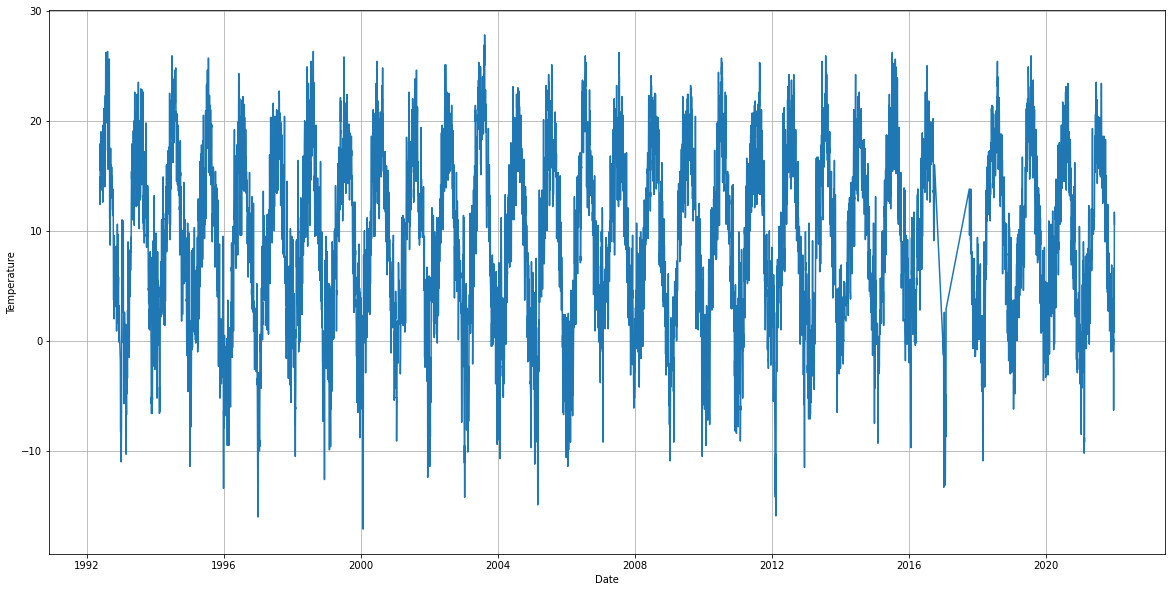

In [10]:
# Plot target value
plt.figure(figsize=(20,10))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(data['MESS_DATUM'], data['TMK'])
plt.show()

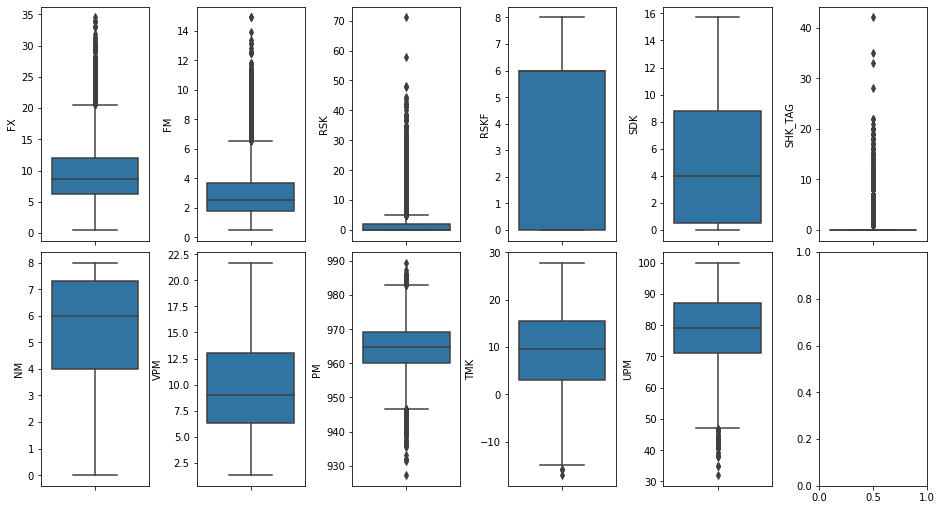

In [11]:
# Print Boxplots
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(13, 7))
ax = ax.flatten()
index = 0
for i in data.iloc[: , 1:]:
  sns.boxplot(y=i, data=data, ax=ax[index])
  index +=1
plt.tight_layout(pad=0.4)
plt.show()

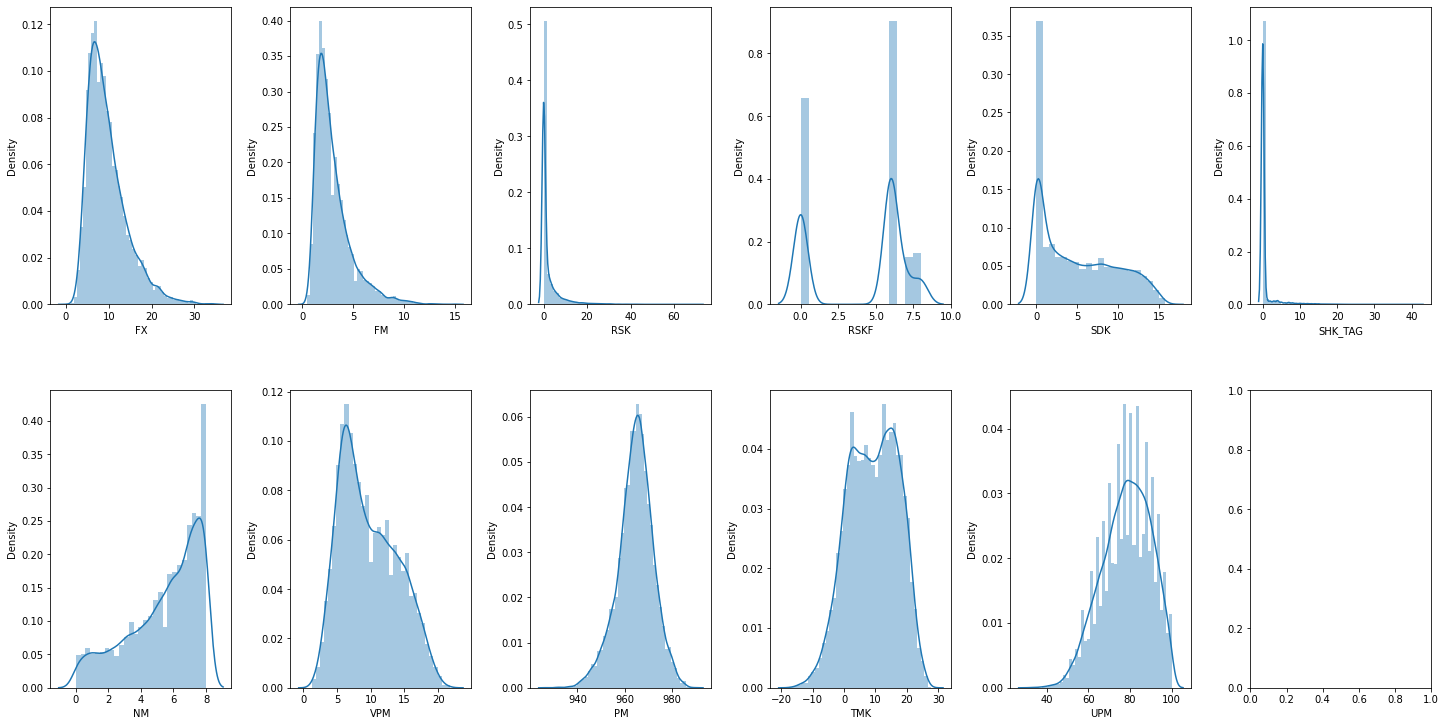

In [12]:
# Plot distplots
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.iloc[: , 1:].items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

<AxesSubplot:>

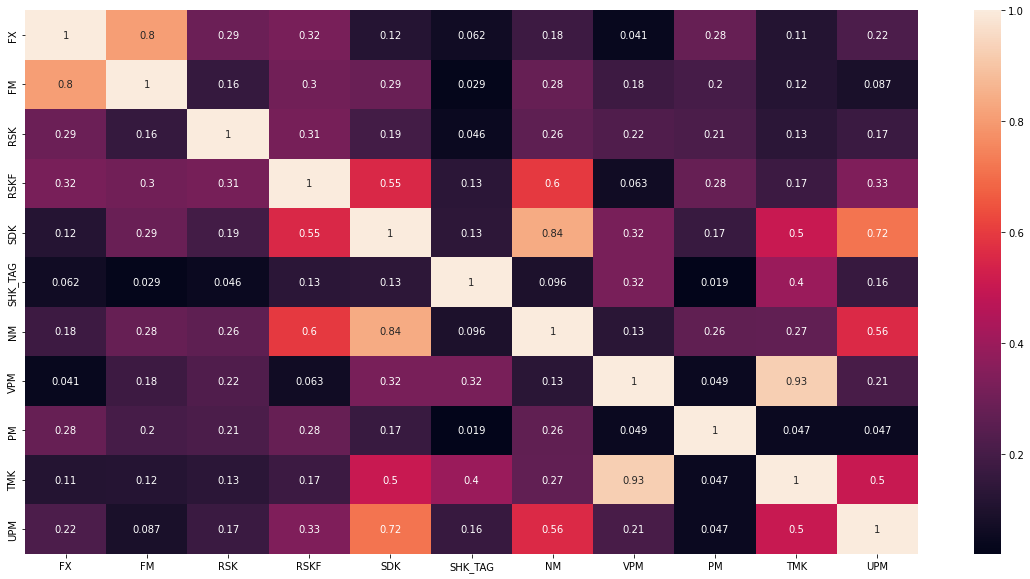

In [13]:
# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(), annot=True)

In [14]:
# Let´s drop the categorical column RSKF, I guess it´s not as much important as others
data = data.drop(columns=['RSKF'])

In [15]:
# Get percentage of outliers in every column
for k, v in data.iloc[: , 1:].items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column FX outliers = 3.23%
Column FM outliers = 5.45%
Column RSK outliers = 13.40%
Column SDK outliers = 0.00%
Column SHK_TAG outliers = 100.00%
Column NM outliers = 0.00%
Column VPM outliers = 0.00%
Column PM outliers = 2.38%
Column TMK outliers = 0.03%
Column UPM outliers = 0.39%


Outliers are not too crazy so I guess we are fine with that

In [16]:
data1 = data.copy()
data1 = data1[['FX', 'FM', 'RSK', 'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'UPM', 'TMK']]

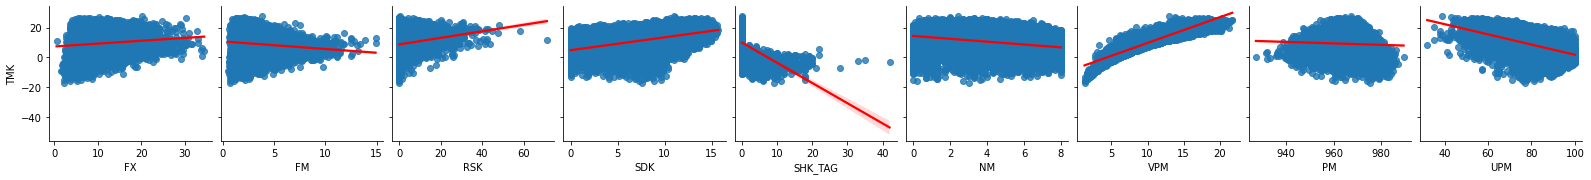

In [17]:
pp = sns.pairplot(data=data1,
                  y_vars=['TMK'],
                  x_vars=['FX', 'FM', 'RSK', 'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'UPM'],
                  kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

---
# Basic FbProphet
The input to Prophet is always a dataframe with two columns **ds** and **y**. The **ds** (datestamp) column should be of the format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The **y** column must be numeric, and represents the measurement we wish to furecast. 

In [18]:
# Select columns
data = data[['MESS_DATUM', 'TMK']]

In [19]:
# Rename the columns
data = data.rename({'MESS_DATUM': 'ds', 'TMK': 'y'}, axis=1)

In [20]:
# Train Prophet model
m = Prophet()
m.fit(data)

18:13:27 - cmdstanpy - INFO - Chain [1] start processing
18:13:27 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Create a new dataframe with future values
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
10633,2022-12-27
10634,2022-12-28
10635,2022-12-29
10636,2022-12-30
10637,2022-12-31


In [22]:
# Run prediction
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
10633,2022-12-27,0.551395,-4.432871,5.360417
10634,2022-12-28,0.474903,-4.662124,5.162796
10635,2022-12-29,0.494785,-4.171287,5.379766
10636,2022-12-30,0.371641,-4.202511,5.204993
10637,2022-12-31,0.266285,-4.676335,4.866170


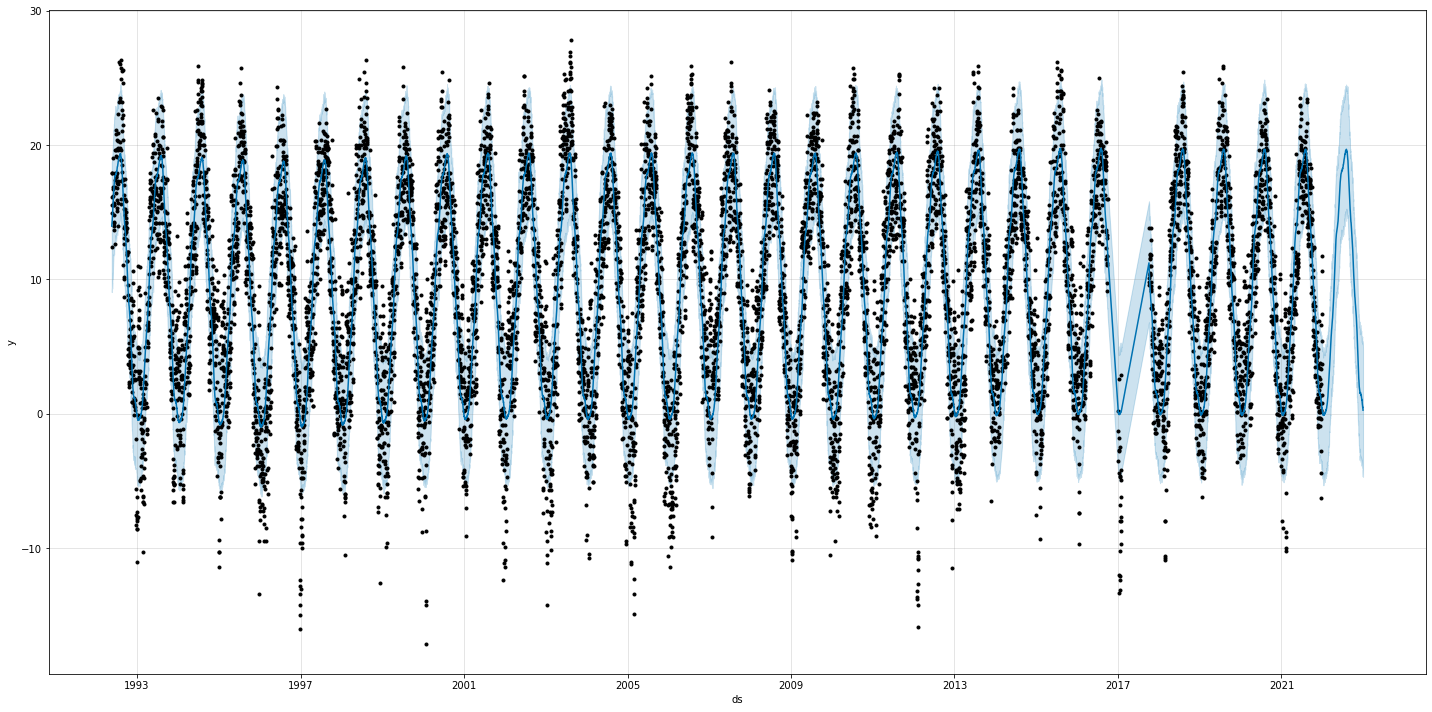

In [23]:
# Plot the forecast
fig1 = m.plot(forecast, figsize=(20, 10))

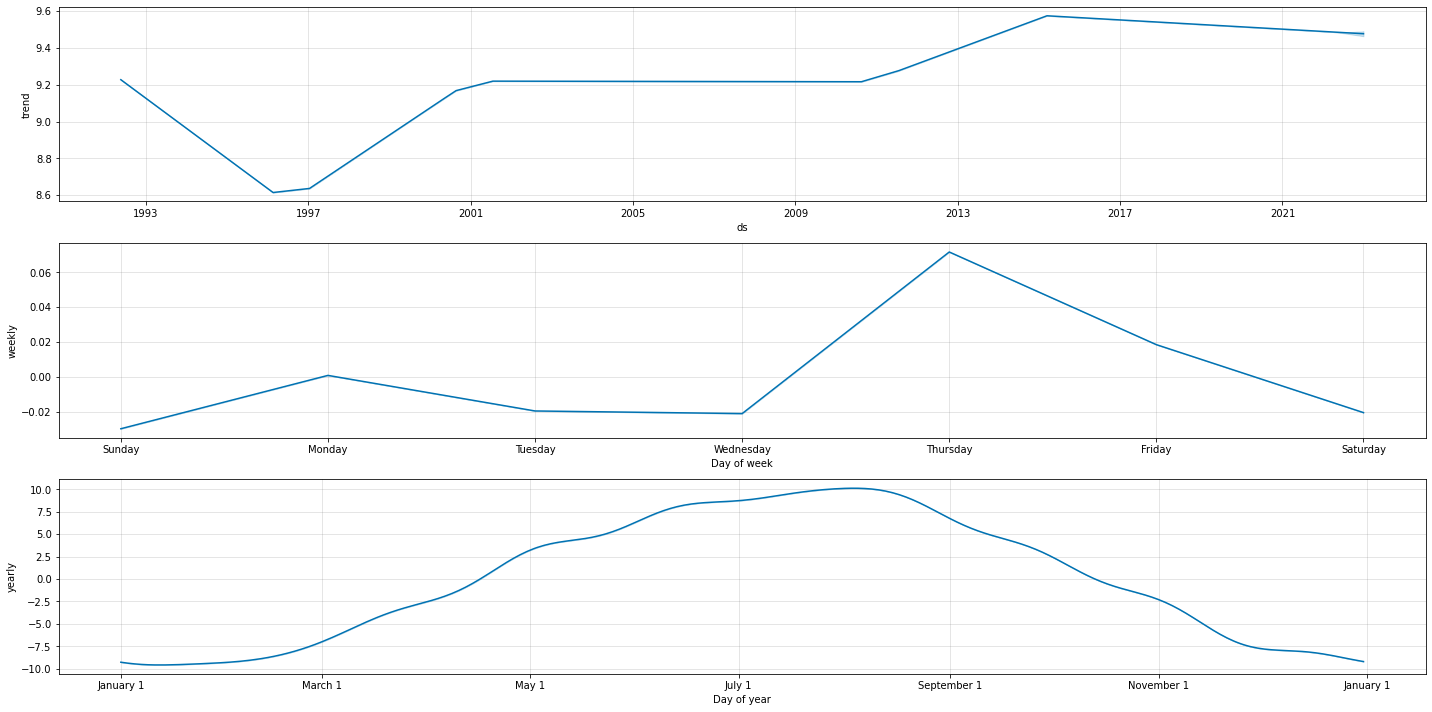

In [24]:
fig2 = m.plot_components(forecast, figsize=(20, 10))

In [25]:
preds = pd.merge(data, forecast, how='inner', left_on=['ds'], right_on=['ds'])

In [26]:
preds = preds[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
preds

,ds,y,yhat,yhat_lower,yhat_upper
0,1992-05-20,14.9,13.957145,9.050243,18.677314
1,1992-05-21,12.4,14.140597,9.306803,18.771447
2,1992-05-22,16.1,14.187677,9.391224,18.783373
3,1992-05-23,17.9,14.258712,9.776219,18.980004
4,1992-05-24,15.5,14.369215,9.308997,19.139229
...,...,...,...,...,...
10268,2021-12-27,1.4,0.565421,-3.857650,5.280154
10269,2021-12-28,3.7,0.470467,-4.369115,4.947262
10270,2021-12-29,7.4,0.396758,-4.295472,4.931459
10271,2021-12-30,11.7,0.420381,-4.001669,5.520631


In [30]:
print(f"MAE: {mean_absolute_error(preds['y'], preds['yhat'])}")

MAE: 2.935584072256069


In [31]:
print(f"MSE: {mean_squared_error(preds['y'], preds['yhat'])}")

MSE: 13.733917985501387


---
# Run weather prediction for year 2022

In [52]:
df = pd.DataFrame(pd.date_range(start='2022-01-01', end='2022-12-31'), columns=['ds'])

In [53]:
df.head()

,ds
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05


In [54]:
# apply model to new dataframe
forecast = m.predict(df)

In [55]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,9.489766,-4.689838,4.766208,9.489766,9.489766,-9.287923,-9.287923,-9.287923,-0.020521,-0.020521,-0.020521,-9.267402,-9.267402,-9.267402,0.0,0.0,0.0,0.201844
1,2022-01-02,9.489732,-4.574068,5.046166,9.489732,9.489732,-9.353314,-9.353314,-9.353314,-0.029788,-0.029788,-0.029788,-9.323526,-9.323526,-9.323526,0.0,0.0,0.0,0.136418
2,2022-01-03,9.489698,-4.397280,4.898507,9.489698,9.489698,-9.373598,-9.373598,-9.373598,0.000835,0.000835,0.000835,-9.374433,-9.374433,-9.374433,0.0,0.0,0.0,0.116100
3,2022-01-04,9.489663,-4.622670,4.830602,9.489663,9.489663,-9.439439,-9.439439,-9.439439,-0.019583,-0.019583,-0.019583,-9.419856,-9.419856,-9.419856,0.0,0.0,0.0,0.050224
4,2022-01-05,9.489629,-4.742285,4.645254,9.489629,9.489629,-9.480728,-9.480728,-9.480728,-0.021084,-0.021084,-0.021084,-9.459644,-9.459644,-9.459644,0.0,0.0,0.0,0.008901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,9.477436,-4.280658,5.072776,9.461087,9.492306,-8.926041,-8.926041,-8.926041,-0.019583,-0.019583,-0.019583,-8.906458,-8.906458,-8.906458,0.0,0.0,0.0,0.551395
361,2022-12-28,9.477402,-3.755639,4.962925,9.460991,9.492346,-9.002498,-9.002498,-9.002498,-0.021084,-0.021084,-0.021084,-8.981414,-8.981414,-8.981414,0.0,0.0,0.0,0.474903
362,2022-12-29,9.477367,-4.246215,5.040522,9.460899,9.492402,-8.982583,-8.982583,-8.982583,0.071662,0.071662,0.071662,-9.054245,-9.054245,-9.054245,0.0,0.0,0.0,0.494785
363,2022-12-30,9.477333,-4.207661,5.220396,9.460810,9.492445,-9.105692,-9.105692,-9.105692,0.018479,0.018479,0.018479,-9.124171,-9.124171,-9.124171,0.0,0.0,0.0,0.371641


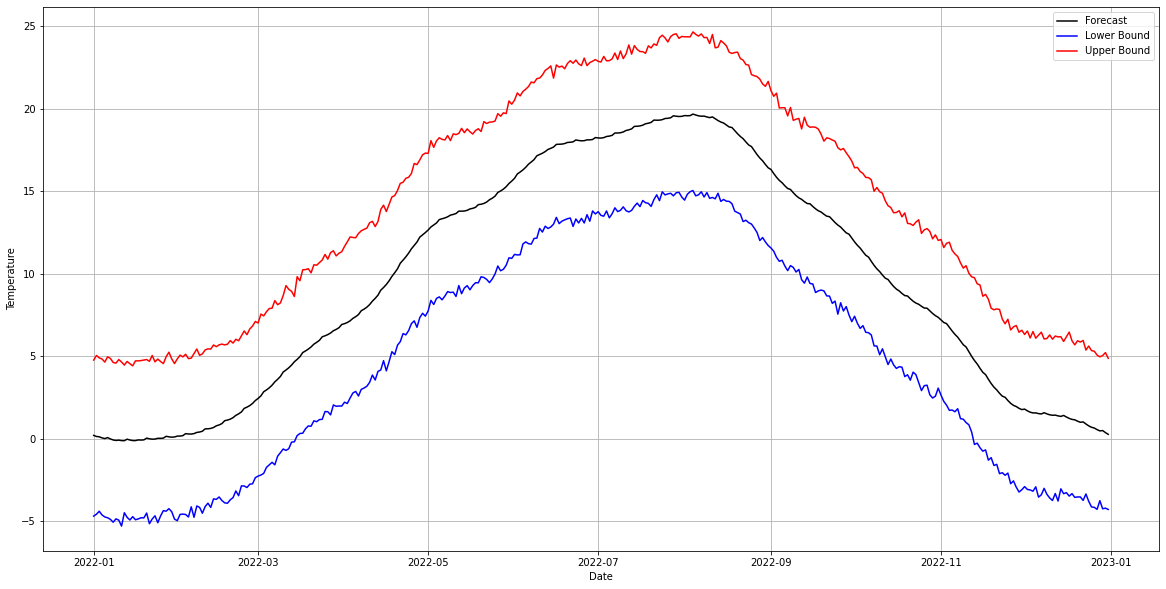

In [74]:
plt.figure(figsize=(20,10))
plt.grid()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(forecast['ds'], forecast['yhat'], color='black',  label='Forecast')
plt.plot(forecast['ds'], forecast['yhat_lower'], color='blue', label='Lower Bound')
plt.plot(forecast['ds'], forecast['yhat_upper'], color='red', label='Upper Bound')
plt.legend()
plt.show()

At first glance, the predictions look right. The temperature increases during the year, has its maximum in August and decreases again towards December. However, the 20 degree mark is never exceeded. It also never gets colder than 0 degrees. That is quite unusual for Germany. It must be tested whether adding additional regressors makes the forecast more accurate. 